<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="6"> TAF MCE - 2021</span></p>
<p><font size="5">  UE C - Numerical Methods </font></p>
<p></p>
<p><font size="4">  Parallel computing in Julia </font></p>
</p></br>
<p><b><font size="4"> By Martina María BALBI ANTUNES and Kevin MICHALEWICZ </font></b></p>
</p>
</CENTER>

In [1]:
# using Pkg
# Pkg.add("Images")
# Pkg.add("MAT")

using MAT
using Plots
using Images
using Distributed
CPU_CORES = 4 # number of cores on the machine
addprocs(CPU_CORES - 1);
@everywhere using LinearAlgebra

using Distributed

pyplot()

file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

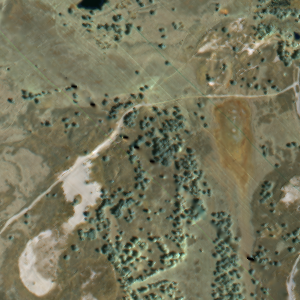

In [2]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB,permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

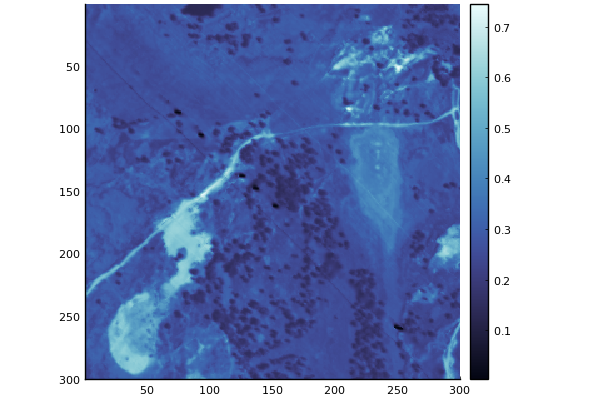

In [3]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice)

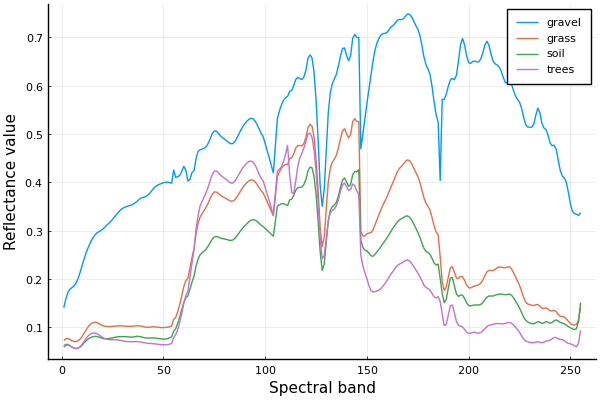

In [4]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

# Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [5]:
img_small = img[1:100,1:100,:]; # use a small crop of the image first
# img_small = copy(img);

# Introduction

The idea is to implement a projected gradient descent algorithm coded by us in a standard serial way and then using parallelization. After that, we perform a similar analysis using Julia libraries. 

# Serial computing

## Projected gradient descent algorithm

In [6]:
size(img_small)

(100, 100, 255)

In [7]:
#X = reshape(img_small, size(img_small)[1]^2, 255)' # we work with images that are vectors
X = reshape(img, size(img)[1]^2, 255)'
size(X)

(255, 90000)

In [39]:
@everywhere function ProjectedGradientDescent(X,S,f,∇f,f_stepsize)
    
    """
    projected gradient descent
    IN:
    ---
    X: data matrix
    S: endmember matrix
    f, ∇f: function to be minimized and its gradient
    OUT:
    ----
    A: abundance matrix
    """
    
    # Initialization 
    N, p = size(X,2), size(S,2)
    A_init = max.(zeros(p,N),rand(p,N))
    A = A_init
    precision = 1.e-4
    δ = 1 # we compute the norm of the difference of A between iterations i and i+1
    opt_stepsize =  0.012 # 2/opnorm(S'*S)
    final_stepsize = f_stepsize
    max_iter = 5000
    nb_iter_pgrad = 0 # number of iterations
    
    # Loop
    while ((δ > precision) || (δ == 0.0)) & (nb_iter_pgrad < max_iter)
        
        nb_iter_pgrad += 1
        A_hat = max.(zeros(p,N), A - opt_stepsize * ∇f(A,X,S))
        δ = norm(A - A_hat)
        A = A_hat
    end
    
    # Final iteration
    A = A./sum(A, dims=1)
    A = max.(zeros(p,N), A - final_stepsize * ∇f(A,X,S))
    A = A./sum(A, dims=1)
    
    return A
    
end

In [9]:
function plotFourMaps(A)
    heatmaps = []
    labels = ["Gravel", "Grass", "Soil", "Trees"]
    for i in 1:size(S,2)
        push!(heatmaps, heatmap(reshape(A[i,:], Int(sqrt(N)), Int(sqrt(N))), yflip=true, aspect_ratio=1, c=:ice, title=labels[i]))
    end
    plot(heatmaps...,layout=size(S,2), size=(800,600))
end

plotFourMaps (generic function with 1 method)

In [47]:
using LinearAlgebra: opnorm, norm

N = size(X,2)
S = sources
A = zeros(size(S,2), N)
f_stepsize = 0.005
@everywhere f(A,X,S)= (1/2)*tr((X-S*A)'*(X-S*A))
@everywhere ∇f(A,X,S) = S'*(S*A - X)

In [ ]:
@time begin
    for j = 1:N
        A[:,j] = ProjectedGradientDescent(X[:,j],S,f,∇f,f_stepsize)
    end
end

In [11]:
A[:,1]

4-element Vector{Float64}:
 0.023229025021248444
 0.4764871500882166
 0.10688971922184597
 0.3933941056686891

In [12]:
sum(reshape(A[1,:], Int(sqrt(N)), Int(sqrt(N))))

8650.756318056012

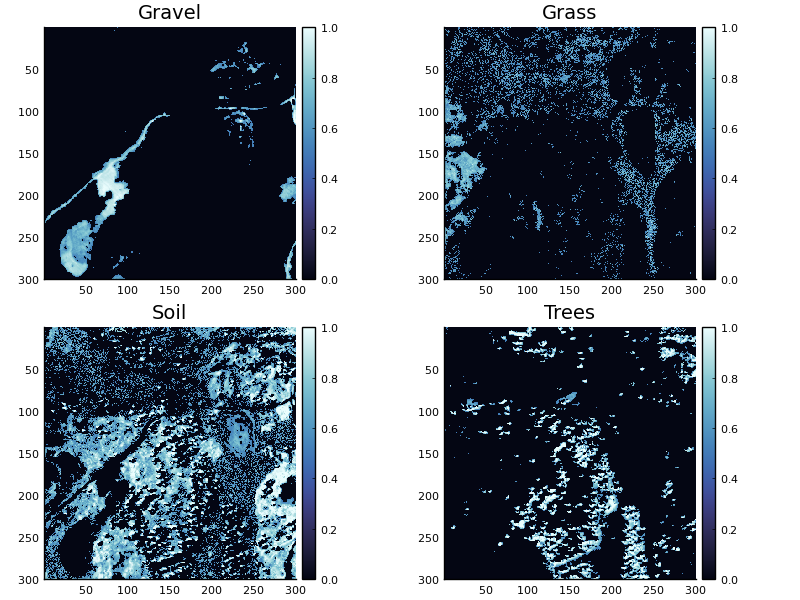

In [13]:
plotFourMaps(A.*(A.>0.5))

## interpretacion de los mapas obtenidos (va a ser la misma interpretacion siempre)

In [14]:
# This option takes a lot of time

A = zeros(size(S,2), N)
f_stepsize = 0.0005

@time begin
    A = ProjectedGradientDescent(X,S,f,∇f,f_stepsize)
end

1470.401043 seconds (515.31 k allocations: 1.749 TiB, 8.38% gc time, 0.03% compilation time)


4×90000 Matrix{Float64}:
 0.00214209  0.00247323  0.00189494  …  0.0425309  0.0668228  0.0576854
 0.575167    0.561028    0.60976        0.163715   0.116669   0.115995
 0.00112544  0.0810477   0.157033       0.793754   0.816508   0.826319
 0.421566    0.355451    0.231312       0.0        0.0        0.0

In [15]:
sum(A)

90000.0

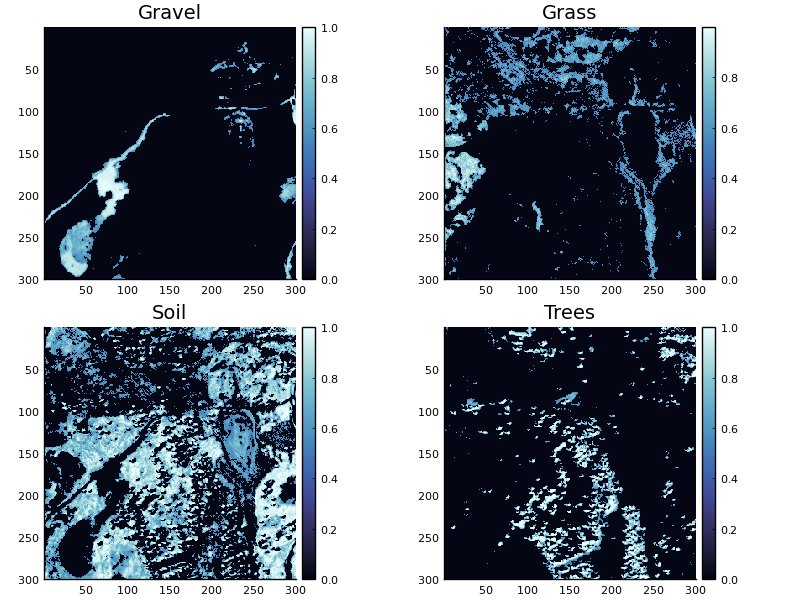

In [16]:
plotFourMaps(A.*(A.>0.5))

In [17]:
A = zeros(size(S,2), N)
f_stepsize = 0.0005

@time begin
    for j = 1:N÷8:N
        A[:,j:j+N÷8-1] = ProjectedGradientDescent(X[:,j:j+N÷8-1],S,f,∇f,f_stepsize)
    end
end

1275.310397 seconds (892.68 k allocations: 1.749 TiB, 19.19% gc time, 0.03% compilation time)


In [18]:
sum(A)

90000.0

In [19]:
A

4×90000 Matrix{Float64}:
 0.00214198  0.00244272  0.00200195  …  0.0429654  0.0668223  0.0577508
 0.575191    0.568985    0.582024       0.0913788  0.120826   0.0887661
 0.0011254   0.0719928   0.187732       0.865656   0.812352   0.853483
 0.421542    0.356579    0.228242       0.0        0.0        0.0

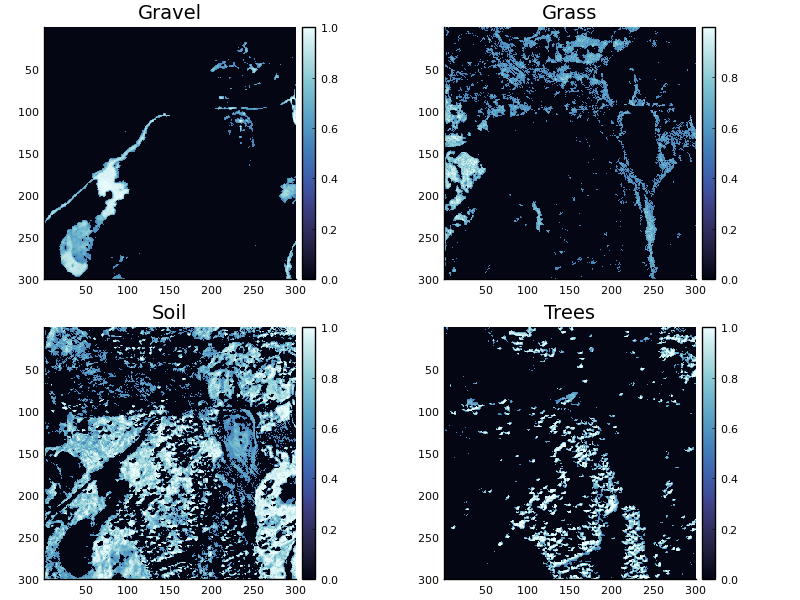

In [20]:
plotFourMaps(A.*(A.>0.5))

## Julia libraries
In the following section we try to solve the problem by using the Julia's JuMP modeling language. Particularly, we will try out the performance using the ECOS and the Ipopt optimizers.

In [49]:
@everywhere using JuMP, ECOS, Ipopt

@everywhere function JuliaLibrariesJuMP(X,S,optimizer)
    """
    solution using Julia's JuMP modeling language
    IN:
    ---
    X: data matrix
    S: endmember matrix
    optimizer: optimizer to use (ECOS or Ipopt)
    OUT:
    ----
    A: abundance matrix
    """
    N, p = size(X,2), size(S,2)

    if optimizer == "ECOS"
        m = Model(with_optimizer(ECOS.Optimizer))
    elseif optimizer == "Ipopt"
        m = Model(with_optimizer(Ipopt.Optimizer))
    end
    
    @variable(m, A[1:p, 1:N])

    @constraint(m, A .>= 0)
    for i in 1:N
        @constraint(m, sum(A[:,i])==1)
    end
    
    @objective(m, Min, (1/2)*tr((X-S*A)'*(X-S*A)))
    
    set_silent(m)

    optimize!(m)

    return value.(A)

end

We will run the algorithm performing a pixelwise approach (others seem to take too much time).

Results with ECOS optimizer:

In [22]:
N = size(X,2)
S = sources

A = zeros(size(S,2), N)

@time begin
    for i = 1:N
        A[:,i] = JuliaLibrariesJuMP(X[:,i],S,"ECOS");
        if i%1000 == 0
            println(i)
        end
    end
end

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
242.324775 seconds (1.34 G allocations: 103.412 GiB, 7.80% gc time, 1.64% compilation time)


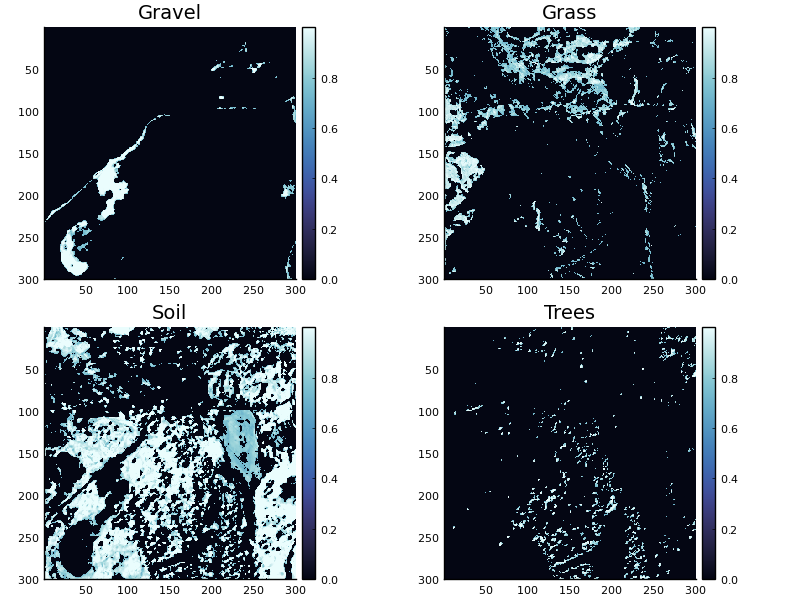

In [23]:
reshape(A[2,:], Int(sqrt(N)), Int(sqrt(N)))

plotFourMaps(A.*(A.>0.7))

Results with Ipopt optimizer:

In [24]:
A = zeros(size(S,2), N)

@time begin
    for i = 1:N
        A[:,i] = JuliaLibrariesJuMP(X[:,i],S,"Ipopt")
        if i%1000 == 0
            println(i)
        end
    end
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
844.135624 seconds (1.18 G allocations: 92.173 GiB, 2.00% gc time, 0.04% compilati

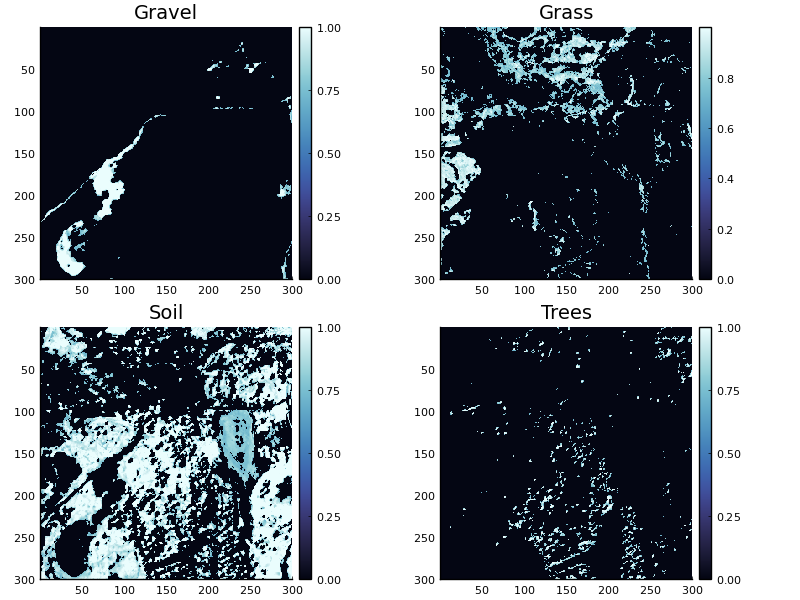

In [25]:
reshape(A[2,:], Int(sqrt(N)), Int(sqrt(N)))

plotFourMaps(A.*(A.>0.7))

Tal optimizer llevo tanto, tal otro tanto, en comparacion a projected gradient descent bla bla

# Parallel computing

In this section we will be implementing the same algorithms as in the previous one but this time these will be executed in parallel taking full advantage of the computer's cores. This problem is embarrassingly parallel, since the result is the sum of several independent tasks that must be done across each pixel. Therefore, it would appear to be convenient to parallelize the problem to obtain faster results.

In order to do this, we will be particularily using the function pmap from the library Distributed. First, it makes sense to check the avaiable workers on the computer (pmap, if not specified otherwise, uses all available workers when implementing the algorithm).

In [50]:
using Distributed

CPU_CORES = length(Sys.cpu_info())

println("CPU cores: ", CPU_CORES)

# Before adding workers.
nprocs()
nworkers() # when there is no extra workers, nprocs() = nworkers().

# After adding them.
addprocs(CPU_CORES - 1)
nprocs()
nworkers()

CPU cores: 4


12

In [51]:
@everywhere using LinearAlgebra: opnorm, norm
@everywhere using MAT

@everywhere file = matopen("project_data.mat")
@everywhere S = read(file,"sources")

## Projected gradient descent algorithm

In [55]:
@everywhere f(A,X,S)= (1/2)*tr((X-S*A)'*(X-S*A))
@everywhere ∇f(A,X,S) = S'*(S*A - X)

@everywhere function ProjectedGradientDescent(X,S,f,∇f,f_stepsize)
    
    """
    projected gradient descent
    IN:
    ---
    X: data matrix
    S: endmember matrix
    f, ∇f: function to be minimized and its gradient
    OUT:
    ----
    A: abundance matrix
    """
    
    # Initialization 
    N, p = size(X,2), size(S,2)
    A_init = max.(zeros(p,N),rand(p,N))
    A = A_init
    precision = 1.e-4
    δ = 1 # we compute the norm of the difference of A between iterations i and i+1
    opt_stepsize =  0.012 # 2/opnorm(S'*S)
    final_stepsize = f_stepsize
    max_iter = 5000
    nb_iter_pgrad = 0 # number of iterations
    
    # Loop
    while ((δ > precision) || (δ == 0.0)) & (nb_iter_pgrad < max_iter)
        
        nb_iter_pgrad += 1
        A_hat = max.(zeros(p,N), A - opt_stepsize * ∇f(A,X,S))
        δ = norm(A - A_hat)
        A = A_hat
    end
    
    # Final iteration
    A = A./sum(A, dims=1)
    A = max.(zeros(p,N), A - final_stepsize * ∇f(A,X,S))
    A = A./sum(A, dims=1)
    
    return A
    
end

In [56]:
using Distributed: pmap
f_stepsize = 0.005

A = @time pmap(Xi->ProjectedGradientDescent(Xi,S,f,∇f,f_stepsize), [X[:,j] for j = 1:N]);

241.803835 seconds (6.62 M allocations: 676.248 MiB, 1.23% gc time, 0.12% compilation time)


In [57]:
A = hcat(A...)

4×90000 Matrix{Float64}:
 0.0238011  0.0255981  0.0173953  …  0.0178698  0.0449658  0.0389895
 0.460501   0.478302   0.611709      0.303954   0.22052    0.172757
 0.124188   0.159292   0.146737      0.678176   0.734514   0.788253
 0.39151    0.336807   0.224159      0.0        0.0        0.0

In [58]:
size(A)

(4, 90000)

In [59]:
sum(reshape(A[1,:], Int(sqrt(N)), Int(sqrt(N))))

8654.034271780753

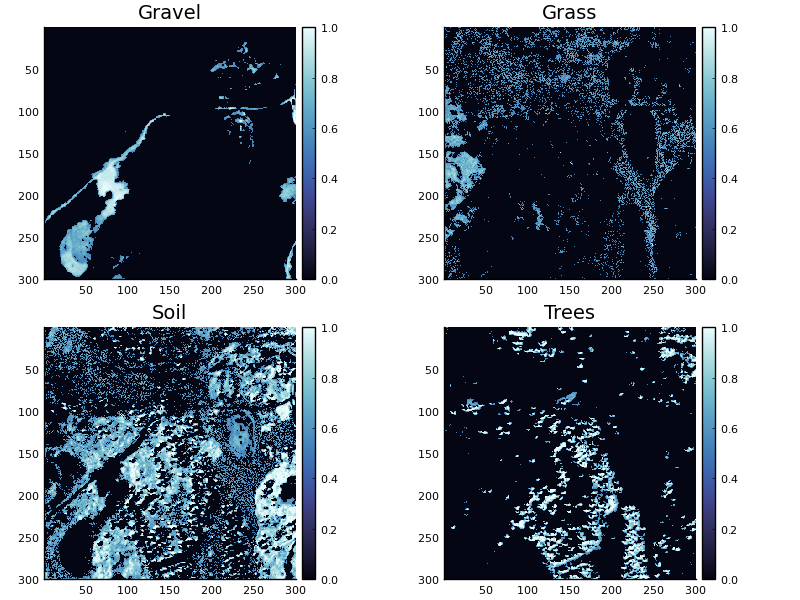

In [60]:
plotFourMaps(A.*(A.>0.5))

In [61]:
f_stepsize = 0.0005

A = @time pmap(Xi->ProjectedGradientDescent(Xi,S,f,∇f,f_stepsize), [X[:,j:j+N÷8-1] for j = 1:N÷8:N]);

424.772125 seconds (228.87 k allocations: 191.067 MiB, 0.05% compilation time)


In [62]:
A = hcat(A...)
size(A)

(4, 90000)

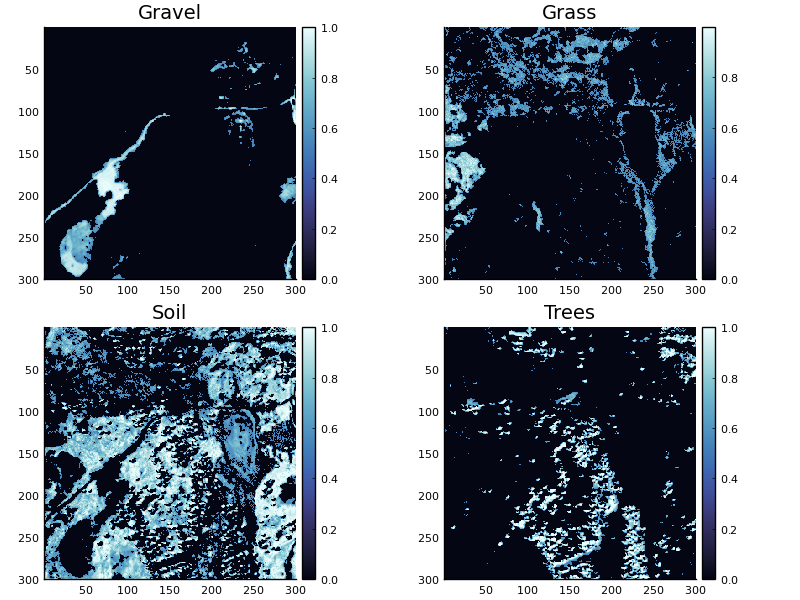

In [63]:
plotFourMaps(A.*(A.>0.5))

## Julia libraries

Here we will parallelize the function that was implemented using Julia libraries. The collection of inputs will be all the pixels, since we already identified that the function that is applied to each pixel proves to be an embarrassingly parallel problem. 

In [73]:
@everywhere using JuMP, ECOS, Ipopt
@everywhere using LinearAlgebra: tr

@everywhere function JuliaLibrariesJuMP(X,S,optimizer)
    """
    solution using Julia's JuMP modeling language
    IN:
    ---
    X: data matrix
    S: endmember matrix
    optimizer: optimizer to use (ECOS or Ipopt)
    OUT:
    ----
    A: abundance matrix
    """
    N, p = size(X,2), size(S,2)

    if optimizer == "ECOS"
        m = Model(with_optimizer(ECOS.Optimizer))
    elseif optimizer == "Ipopt"
        m = Model(with_optimizer(Ipopt.Optimizer))
    end
    
    @variable(m, A[1:p, 1:N])

    @constraint(m, A .>= 0)
    for i in 1:N
        @constraint(m, sum(A[:,i])==1)
    end
    
    @objective(m, Min, (1/2)*tr((X-S*A)'*(X-S*A)))
    
    set_silent(m)

    optimize!(m)

    return value.(A)

end

In [74]:
X_parallel = [X[:,k] for k = 1:N]

A = @time pmap(Xi->JuliaLibrariesJuMP(Xi,S,"ECOS"),X_parallel);

246.768254 seconds (6.25 M allocations: 478.640 MiB, 1.83% gc time, 0.12% compilation time)


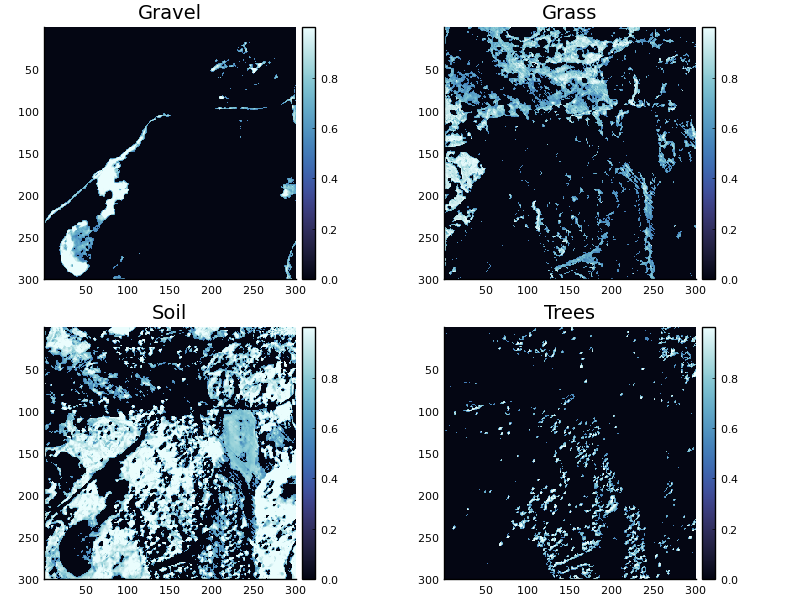

In [75]:
A = hcat(A...)

plotFourMaps(A.*(A.>0.5))